# Installing Pyspark

In [1]:
# Install pyspark
!pip install pyspark
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark
# Import a Spark function from library
from pyspark.sql.functions import col
spark.stop()

## Import necessary modules

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType


##  Creating a spark session and increasing the driver memory to 6gb.

In [3]:
spark = SparkSession.builder \
        .appName("Crimes_-_2001_to_Present") \
        .config("spark.driver.memory", "6g") \
        .getOrCreate()


In [4]:
# Define schema for Chicago Crime Data
crime_schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("Case Number", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary Type", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location Description", StringType(), True),
    StructField("Arrest", StringType(), True),
    StructField("Domestic", StringType(), True),
    StructField("Beat", StringType(), True),
    StructField("District", StringType(), True),
    StructField("Ward", StringType(), True),
    StructField("Community Area", StringType(), True),
    StructField("FBI Code", StringType(), True),
    StructField("X Coordinate", DoubleType(), True),
    StructField("Y Coordinate", DoubleType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", TimestampType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True)
])


In [5]:
# Load the Chicago Crime Data
crime_df = spark.read.format("csv") \
                .option("header", True) \
                .option("inferSchema", False) \
                .schema(crime_schema) \
                .load("Crimes_-_2001_to_Present.csv")


## Displaying the crime_df 

In [6]:
crime_df.show()

+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|10224738|   HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|

## Removing null values

In [7]:
crime_df = crime_df.na.drop(subset=['ID','Case Number'])

In [8]:
crime_df.show()

+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|10224738|   HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|

In [9]:
# Change the data type of 'Date' column
from pyspark.sql.functions import to_timestamp
crime_df = crime_df.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))


In [10]:
# Filter the data for the last ten years
from pyspark.sql.functions import year
current_year = 2023
crime_df = crime_df.filter(year("Date") >= current_year - 10)


In [11]:
#importing the pyspark.sql.functions module 
from pyspark.sql import functions as F

In [12]:
# Filter out the specified crime types
crime_filtered = crime_df.filter(~F.col("Primary Type").isin(
    'NON-CRIMINAL (SUBJECT SPECIFIED)',
    'OTHER OFFENSE',
    'STALKING',
    'NON - CRIMINAL',
    'ARSON'
))


In [13]:
crime_filtered.show()

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12

## Merging similar crime types

In [14]:
from pyspark.sql.functions import when

crime_filtered = crime_filtered.withColumn("Primary Type",
    when((col("Primary Type") == "SEX OFFENSE") | (col("Primary Type") == "PROSTITUTION"),
         "SEXUAL OFFENSE").otherwise(col("Primary Type")))



In [15]:
crime_filtered.show()

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12

# Visualization

## Show year-wise trend of the crime for last ten years

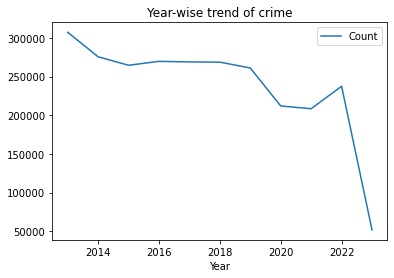

In [16]:
# importing year and count
from pyspark.sql.functions import year, count
import matplotlib.pyplot as plt

# Group the data by year and count the number of crimes
year_count = crime_df.filter(year("Date") >= current_year - 10).groupBy(year("Date").alias("Year")).agg(count("*").alias("Count")).orderBy("Year")

# Convert the result to a Pandas DataFrame and plot the data
year_count_pd = year_count.toPandas()
year_count_pd.plot(x="Year", y="Count", kind="line", title="Year-wise trend of crime")
plt.show()


## Find out at which hour of the day crime is highest

In [19]:
from pyspark.sql.functions import hour

# Group the data by hour and count the number of crimes
hour_count = crime_df.groupBy(hour("Date").alias("Hour")).count().orderBy("Hour")

# Get the hour with the highest number of crimes
max_hour = hour_count.orderBy(hour_count["count"].desc()).first()["Hour"]

print("The hour with the highest number of crimes is", max_hour)


The hour with the highest number of crimes is 12


## Find top ten crimes and present them as a bar chart

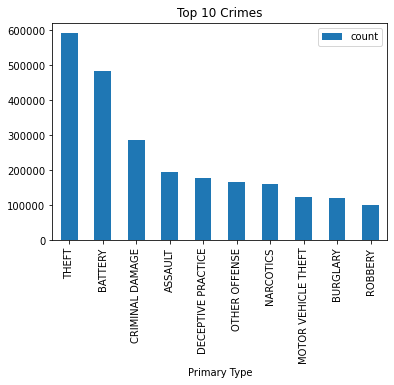

In [20]:
from pyspark.sql.functions import desc

# Group the data by crime type and count the number of crimes
crime_count = crime_df.groupBy("Primary Type").count().orderBy(desc("count")).limit(10)

# Convert the result to a Pandas DataFrame and plot the data
crime_count_pd = crime_count.toPandas()
crime_count_pd.plot(x="Primary Type", y="count", kind="bar", title="Top 10 Crimes")
plt.show()
